In [31]:
library('dplyr')
library('ggplot2')
library('car')
library('prophet')
library('zoo')
library('tidyverse')
library('lubridate')
library('forecast')

In [2]:
# Read in the merged df that includes information about higher ed institutions, student populations, and GDP data.
# This merged dataframe comes from the notebook title 'mgt_6203_group_proj'
df <- read.csv("./merged_df.csv")
head(df)

,X,unitid,year,state,st_fips,institution_name,CIP11ASSOC,CIP11CERT4,CIP11BACHL,CIP14ASSOC,⋯,PCIP11,PCIP14,Official.USPS.Code,gdp_description,gdp,institution_name.Name,cip_code,cip_title,level_code,total
,<int>,<int>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,⋯,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>
1,1,100654,X1998,Alabama,1,Alabama A & M University,0,0,1,0,⋯,0.0643,0.0129,AL,"Data processing, hosting, and other information services",161.6,Alabama A & M University,'14.0801',"Civil Engineering, General",Bachelor's degree,7
2,2,100654,X1998,Alabama,1,Alabama A & M University,0,0,1,0,⋯,0.0643,0.0129,AL,"Data processing, hosting, and other information services",161.6,Alabama A & M University,'11.0101',"Computer & Information Sciences, General",Master's degree,23
3,3,100654,X1998,Alabama,1,Alabama A & M University,0,0,1,0,⋯,0.0643,0.0129,AL,"Data processing, hosting, and other information services",161.6,Alabama A & M University,'11.0101',"Computer & Information Sciences, General",Bachelor's degree,35
4,4,100654,X1998,Alabama,1,Alabama A & M University,0,0,1,0,⋯,0.0643,0.0129,AL,"Miscellaneous professional, scientific, and technical services",3235.3,Alabama A & M University,'14.0801',"Civil Engineering, General",Bachelor's degree,7
5,5,100654,X1998,Alabama,1,Alabama A & M University,0,0,1,0,⋯,0.0643,0.0129,AL,"Miscellaneous professional, scientific, and technical services",3235.3,Alabama A & M University,'11.0101',"Computer & Information Sciences, General",Master's degree,23
6,6,100654,X1998,Alabama,1,Alabama A & M University,0,0,1,0,⋯,0.0643,0.0129,AL,"Miscellaneous professional, scientific, and technical services",3235.3,Alabama A & M University,'11.0101',"Computer & Information Sciences, General",Bachelor's degree,35


In [3]:
# Group both student counts and gdp data by year and state
nstudents <- df %>% 
    group_by(year, state) %>% 
    summarise(nstudents = sum(total))

gdp_info <- df %>% select(year,state,gdp)
gdp <- distinct(gdp_info) %>% 
    group_by(year,state) %>% 
    summarise(gdp = sum(gdp))

nstudents <- rename(nstudents, student_year = year)
gdp <- rename(gdp, gdp_year = year)

`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.


In [4]:
head(nstudents)

student_year,state,nstudents
<chr>,<chr>,<int>
X1998,Alabama,8220
X1998,Alaska,624
X1998,Arizona,6153
X1998,Arkansas,2664
X1998,California,51141
X1998,Colorado,9822


In [5]:
head(gdp)

gdp_year,state,gdp
<chr>,<chr>,<dbl>
X1998,Alabama,4231.8
X1998,Alaska,686.5
X1998,Arizona,6034.1
X1998,Arkansas,1512.9
X1998,California,71992.3
X1998,Colorado,10340.9


In [6]:
pop_data.long <- read.csv('State_census_pop_1990_to_2020.csv', header = TRUE, colClasses = 'character')
pop_data.df <- pop_data.long[ ,c('Name','Pop..1990','Pop..2000','Pop..2010','Pop..2020')]
colnames(pop_data.df) <- c('State','1990','2000','2010','2020')
pop_data.df <- pivot_longer(pop_data.df, cols = 2:5, names_to='Year' , values_to='Population')
cols <- 2:3
pop_data.df[,cols] <- lapply(pop_data.df[,cols],function(pop_data.df){as.numeric(gsub(",","",pop_data.df))})

In [7]:
state_names <- unique(pop_data.df$State)
missing_yrs <- c(1991:2019)
missing_yrs <- missing_yrs[c(1:9,11:19,21:29)]

In [8]:
# creating df of the years missing from the dataset 
missing_df = data.frame(
  col1 = character(), col2 = numeric(),stringsAsFactors = FALSE)

for (s in state_names) {
                for (y in missing_yrs) {
                    vec <- c(s, y)
                    missing_df[nrow(missing_df)+1, ] <- vec
}}

missing_df <- missing_df %>% add_column(new_col = NA)
colnames(missing_df) <- c('State', 'Year', 'Population')
missing_df$Year <- as.numeric(missing_df$Year)
missing_df$Population <- as.numeric(missing_df$Population)

In [9]:
# appending the missing data years to the data set from the census 
df <- rbind(pop_data.df, missing_df)
df <- df %>% arrange(State,Year)

# linearly interpolating the missing values based on the 10 year census populations
df <- df %>%
        mutate(Population = round(na.approx(Population),0))
pop_df <- df %>% filter(State != 'United States', State != 'Puerto Rico')
colnames(pop_df) <- c('state', 'student_year', 'pop')
head(pop_df)

state,student_year,pop
<chr>,<dbl>,<dbl>
Alabama,1990,4040389
Alabama,1991,4081071
Alabama,1992,4121753
Alabama,1993,4162434
Alabama,1994,4203116
Alabama,1995,4243798


In [10]:
nstudents$student_year <- as.numeric(substring(nstudents$student_year, 2, 5))
gdp$gdp_year <- as.numeric(substring(gdp$gdp_year, 2, 5))

In [11]:
head(nstudents)

student_year,state,nstudents
<dbl>,<chr>,<int>
1998,Alabama,8220
1998,Alaska,624
1998,Arizona,6153
1998,Arkansas,2664
1998,California,51141
1998,Colorado,9822


In [12]:
head(gdp)

gdp_year,state,gdp
<dbl>,<chr>,<dbl>
1998,Alabama,4231.8
1998,Alaska,686.5
1998,Arizona,6034.1
1998,Arkansas,1512.9
1998,California,71992.3
1998,Colorado,10340.9


In [13]:
join_df <- unique(nstudents[ , 'student_year'])
join_df$gdp_year <- join_df$student_year + 5
head(join_df)

student_year,gdp_year
<dbl>,<dbl>
1998,2003
1999,2004
2000,2005
2001,2006
2002,2007
2003,2008


In [14]:
sj_df <- merge(nstudents, join_df, 'student_year', all.x = TRUE)
head(sj_df)

,student_year,state,nstudents,gdp_year
,<dbl>,<chr>,<int>,<dbl>
1,1998,Alabama,8220,2003
2,1998,Alaska,624,2003
3,1998,Arizona,6153,2003
4,1998,Arkansas,2664,2003
5,1998,California,51141,2003
6,1998,Colorado,9822,2003


In [15]:
ts_df <- merge(sj_df, gdp, c('gdp_year', 'state'), all.x = TRUE)
ts_df <- ts_df[!(is.na(ts_df$gdp)), ]
ts_df <- ts_df %>% arrange(state, student_year)
head(ts_df)

,gdp_year,state,student_year,nstudents,gdp
,<dbl>,<chr>,<dbl>,<int>,<dbl>
1,2003,Alabama,1998,8220,5945.5
2,2005,Alabama,2000,8205,6707.3
3,2006,Alabama,2001,9093,7410.3
4,2007,Alabama,2002,9375,7807.6
5,2008,Alabama,2003,9528,8609.1
6,2010,Alabama,2005,9504,9029.8


In [16]:
final_df <- merge(ts_df, pop_df, c('state', 'student_year'), all.x = TRUE)
final_df$nsnorm <- as.numeric(final_df$nstudents) / final_df$pop
final_df$gnorm <- final_df$gdp / final_df$pop
final_df$ds <- as.Date(paste(as.character(final_df$student_year), '-01-01', sep=''), '%Y-%m-%d')
final_df$y <- final_df$gnorm
head(final_df)

,state,student_year,gdp_year,nstudents,gdp,pop,nsnorm,gnorm,ds,y
,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<date>,<dbl>
1,Alabama,1998,2003,8220,5945.5,4365843,0.001882798,0.001361822,1998-01-01,0.001361822
2,Alabama,2000,2005,8205,6707.3,4447207,0.001844978,0.001508205,2000-01-01,0.001508205
3,Alabama,2001,2006,9093,7410.3,4480460,0.002029479,0.001653915,2001-01-01,0.001653915
4,Alabama,2002,2007,9375,7807.6,4513713,0.002077004,0.001729751,2002-01-01,0.001729751
5,Alabama,2003,2008,9528,8609.1,4546966,0.002095463,0.001893372,2003-01-01,0.001893372
6,Alabama,2005,2010,9504,9029.8,4613472,0.002060054,0.001957268,2005-01-01,0.001957268


In [17]:
ns_diff <- final_df %>%
    group_by(state) %>%
        summarize(max_nsnorm = max(nsnorm), min_nsnorm = min(nsnorm))
ns_diff$diff <- ns_diff$max_nsnorm - ns_diff$min_nsnorm
ns_diff <- ns_diff %>% arrange(-diff)
head(ns_diff, 3)
tail(ns_diff, 3)

state,max_nsnorm,min_nsnorm,diff
<chr>,<dbl>,<dbl>,<dbl>
District of Columbia,0.014096569,0.006353756,0.007742812
Arkansas,0.004926854,0.001003350,0.003923504
Arizona,0.004862144,0.001272000,0.003590145


state,max_nsnorm,min_nsnorm,diff
<chr>,<dbl>,<dbl>,<dbl>
Maine,0.001489564,0.0007936490,0.0006959151
Hawaii,0.001574813,0.0009212106,0.0006536026
Tennessee,0.001518260,0.0010518492,0.0004664103


In [18]:
# analyze the top 3 and bottom 3 normalized student increases
regressor_vars = c('ds', 'y', 'nsnorm')

In [19]:
# District of Columbia
dc_data <- final_df[(final_df$state == 'District of Columbia'), regressor_vars]
rownames(dc_data) <- dc_data$ds
dc_mod <- lm(y ~ nsnorm, data=dc_data)
summary(dc_mod)


Call:
lm(formula = y ~ nsnorm, data = dc_data)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0113431 -0.0013032  0.0003657  0.0023579  0.0058072 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.032567   0.004905   6.640 1.11e-05 ***
nsnorm      -0.905838   0.489024  -1.852   0.0852 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.004812 on 14 degrees of freedom
Multiple R-squared:  0.1968,	Adjusted R-squared:  0.1395 
F-statistic: 3.431 on 1 and 14 DF,  p-value: 0.08518


n.changepoints greater than number of observations. Using 11



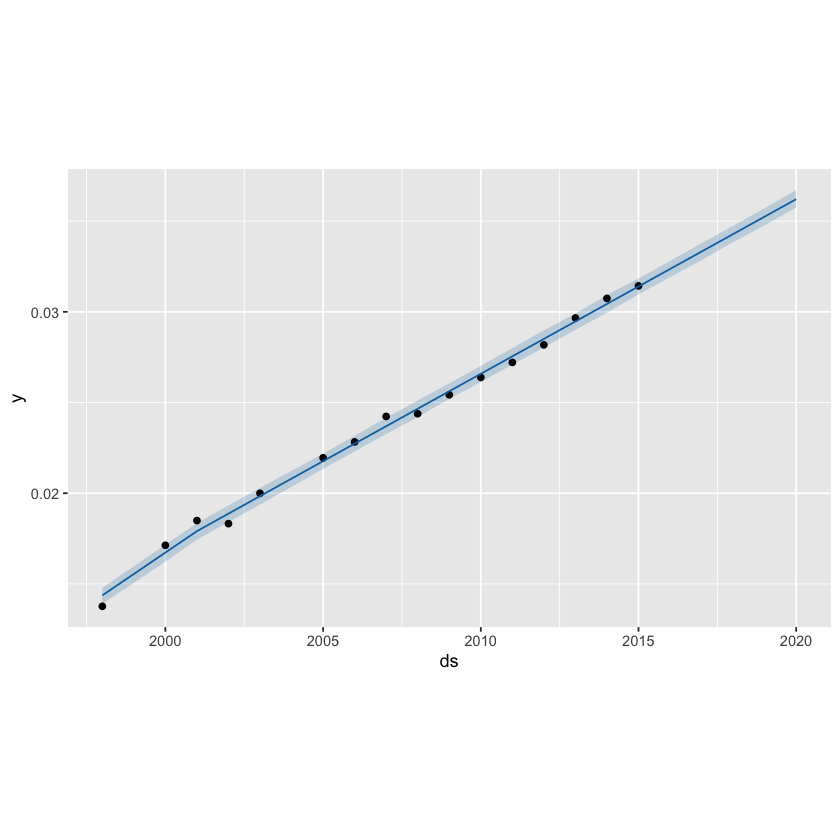

In [20]:
# create a prophet model to show trends over time and plot the 
# forecast for the last two years of gdp vs the actual last two years of gdp
gdp_dc <- dc_data[, c('ds', 'y')]
m_dc_gdp <- prophet(yearly.seasonality=FALSE, weekly.seasonality=FALSE, daily.seasonality=FALSE)
m_dc_gdp <- fit.prophet(m_dc_gdp, gdp_dc)
future <- make_future_dataframe(m_dc_gdp, 5, freq = "year")

# plot forecast from 2 test points with full dataset
forecast <- predict(m_dc_gdp, future)
plot(m_dc_gdp, forecast)

In [21]:
# Arkansas
ark_data <- final_df[(final_df$state == 'Arkansas'), regressor_vars]
rownames(ark_data) <- ark_data$ds
ark_mod <- lm(y ~ nsnorm, data=ark_data)
summary(ark_mod)


Call:
lm(formula = y ~ nsnorm, data = ark_data)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0003800 -0.0001107 -0.0000167  0.0001012  0.0003811 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.0013418  0.0001002  13.393 2.26e-09 ***
nsnorm      -0.0585179  0.0481209  -1.216    0.244    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.0002139 on 14 degrees of freedom
Multiple R-squared:  0.09554,	Adjusted R-squared:  0.03093 
F-statistic: 1.479 on 1 and 14 DF,  p-value: 0.2441


n.changepoints greater than number of observations. Using 11



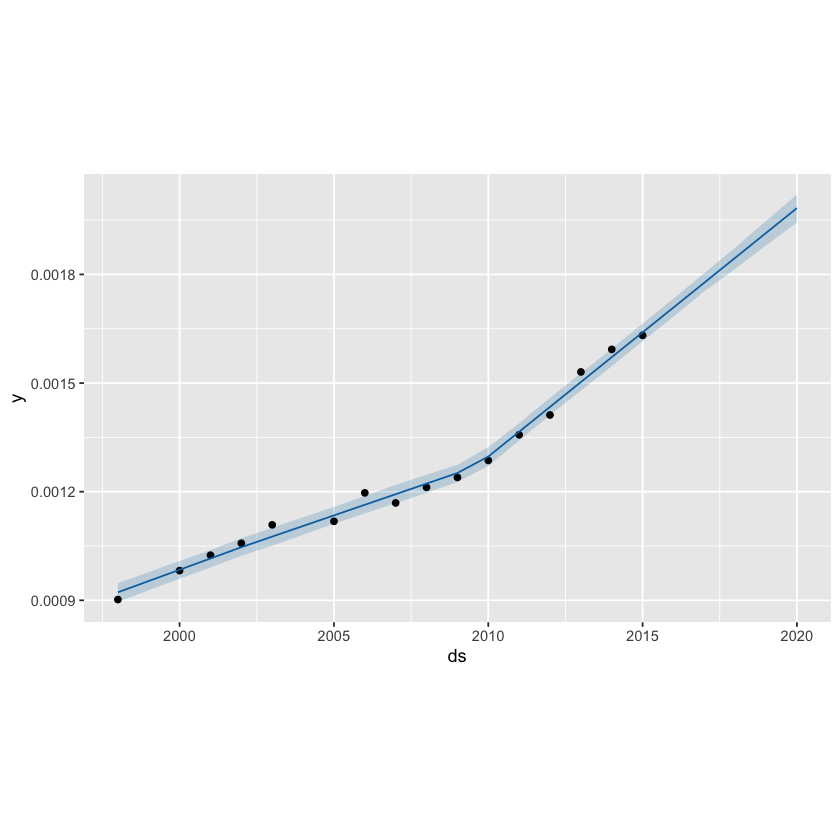

In [22]:
# create a prophet model to show trends over time and plot the 
# forecast for the last two years of gdp vs the actual last two years of gdp
gdp_ark <- ark_data[, c('ds', 'y')]
m_ark_gdp <- prophet(yearly.seasonality=FALSE, weekly.seasonality=FALSE, daily.seasonality=FALSE)
m_ark_gdp <- fit.prophet(m_ark_gdp, gdp_ark)
future <- make_future_dataframe(m_ark_gdp, 5, freq = "year")

# plot forecast from 2 test points with full dataset
forecast <- predict(m_ark_gdp, future)
plot(m_ark_gdp, forecast)

In [23]:
# Arizona
ari_data <- final_df[(final_df$state == 'Arizona'), regressor_vars]
rownames(ari_data) <- ari_data$ds
ari_mod <- lm(y ~ nsnorm, data=ari_data)
summary(ari_mod)


Call:
lm(formula = y ~ nsnorm, data = ari_data)

Residuals:
       Min         1Q     Median         3Q        Max 
-4.706e-04 -1.317e-04 -3.849e-05  1.331e-04  4.670e-04 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.0018351  0.0001677  10.941 3.03e-08 ***
nsnorm      0.3003400  0.0667932   4.497 0.000502 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.0002567 on 14 degrees of freedom
Multiple R-squared:  0.5909,	Adjusted R-squared:  0.5616 
F-statistic: 20.22 on 1 and 14 DF,  p-value: 0.0005025


n.changepoints greater than number of observations. Using 11



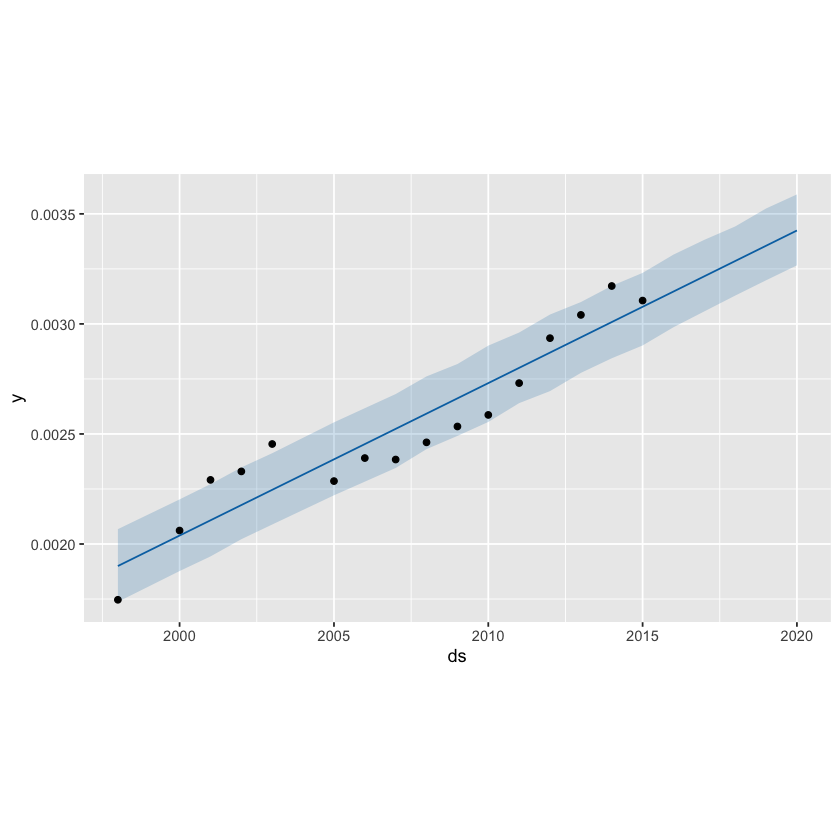

In [24]:
# create a prophet model to show trends over time and plot the 
# forecast for the last two years of gdp vs the actual last two years of gdp
gdp_ari <- ari_data[, c('ds', 'y')]
m_ari_gdp <- prophet(yearly.seasonality=FALSE, weekly.seasonality=FALSE, daily.seasonality=FALSE)
m_ari_gdp <- fit.prophet(m_ari_gdp, gdp_ari)
future <- make_future_dataframe(m_ari_gdp, 5, freq = "year")

# plot forecast from 2 test points with full dataset
forecast <- predict(m_ari_gdp, future)
plot(m_ari_gdp, forecast)

In [25]:
# Maine
mai_data <- final_df[(final_df$state == 'Maine'), regressor_vars]
rownames(mai_data) <- mai_data$ds
mai_mod <- lm(y ~ nsnorm, data=mai_data)
summary(mai_mod)


Call:
lm(formula = y ~ nsnorm, data = mai_data)

Residuals:
       Min         1Q     Median         3Q        Max 
-4.336e-04 -1.915e-04 -9.310e-06  2.105e-04  4.867e-04 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)   
(Intercept) 0.0005790  0.0004285   1.351  0.19809   
nsnorm      1.3513354  0.4224348   3.199  0.00643 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.0002866 on 14 degrees of freedom
Multiple R-squared:  0.4223,	Adjusted R-squared:  0.381 
F-statistic: 10.23 on 1 and 14 DF,  p-value: 0.006434


n.changepoints greater than number of observations. Using 11



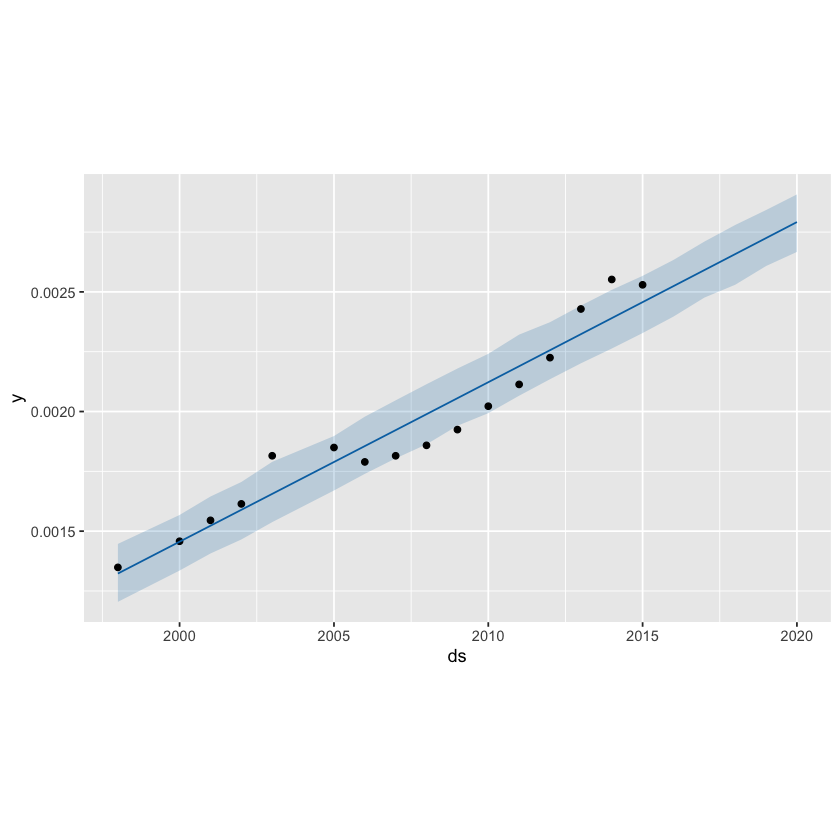

In [26]:
# create a prophet model to show trends over time and plot the 
# forecast for the last two years of gdp vs the actual last two years of gdp
gdp_mai <- mai_data[, c('ds', 'y')]
m_mai_gdp <- prophet(yearly.seasonality=FALSE, weekly.seasonality=FALSE, daily.seasonality=FALSE)
m_mai_gdp <- fit.prophet(m_mai_gdp, gdp_mai)
future <- make_future_dataframe(m_mai_gdp, 5, freq = "year")

# plot forecast from 2 test points with full dataset
forecast <- predict(m_mai_gdp, future)
plot(m_mai_gdp, forecast)

In [27]:
# Hawaii
haw_data <- final_df[(final_df$state == 'Hawaii'), regressor_vars]
rownames(haw_data) <- haw_data$ds
haw_mod <- lm(y ~ nsnorm, data=haw_data)
summary(haw_mod)


Call:
lm(formula = y ~ nsnorm, data = haw_data)

Residuals:
       Min         1Q     Median         3Q        Max 
-5.340e-04 -6.876e-05 -7.720e-06  8.314e-05  3.503e-04 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.0022563  0.0003703   6.093 2.78e-05 ***
nsnorm      -0.2169426  0.3050327  -0.711    0.489    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.0002348 on 14 degrees of freedom
Multiple R-squared:  0.03487,	Adjusted R-squared:  -0.03407 
F-statistic: 0.5058 on 1 and 14 DF,  p-value: 0.4886


n.changepoints greater than number of observations. Using 11



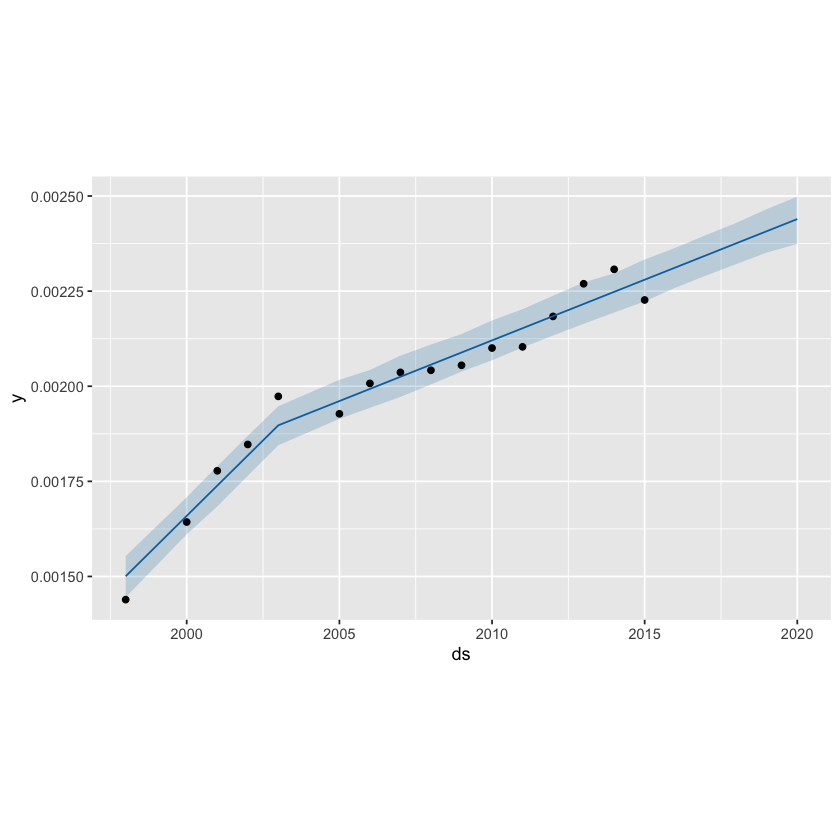

In [28]:
# create a prophet model to show trends over time and plot the 
# forecast for the last two years of gdp vs the actual last two years of gdp
gdp_haw <- haw_data[, c('ds', 'y')]
m_haw_gdp <- prophet(yearly.seasonality=FALSE, weekly.seasonality=FALSE, daily.seasonality=FALSE)
m_haw_gdp <- fit.prophet(m_haw_gdp, gdp_haw)
future <- make_future_dataframe(m_haw_gdp, 5, freq = "year")

# plot forecast from 2 test points with full dataset
forecast <- predict(m_haw_gdp, future)
plot(m_haw_gdp, forecast)

In [29]:
#Tennessee
ten_data <- final_df[(final_df$state == 'Tennessee'), regressor_vars]
rownames(ten_data) <- ten_data$ds
ten_mod <- lm(y ~ nsnorm, data=ten_data)
summary(ten_mod)


Call:
lm(formula = y ~ nsnorm, data = ten_data)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0006336 -0.0004609  0.0001360  0.0002812  0.0006257 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)   
(Intercept) -0.0003476  0.0008527  -0.408  0.68973   
nsnorm       2.1609026  0.6837488   3.160  0.00695 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.0004239 on 14 degrees of freedom
Multiple R-squared:  0.4164,	Adjusted R-squared:  0.3747 
F-statistic: 9.988 on 1 and 14 DF,  p-value: 0.006947


n.changepoints greater than number of observations. Using 11



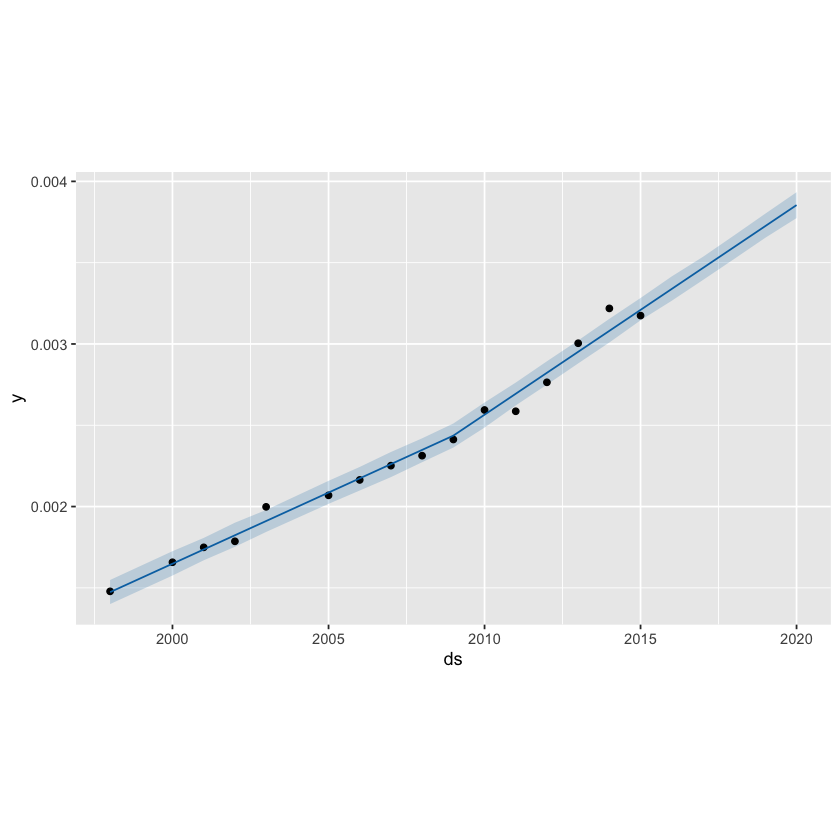

In [30]:
# create a prophet model to show trends over time and plot the 
# forecast for the last two years of gdp vs the actual last two years of gdp
gdp_ten <- ten_data[, c('ds', 'y')]
m_ten_gdp <- prophet(yearly.seasonality=FALSE, weekly.seasonality=FALSE, daily.seasonality=FALSE)
m_ten_gdp <- fit.prophet(m_ten_gdp, gdp_ten)
future <- make_future_dataframe(m_ten_gdp, 5, freq = "year")

# plot forecast from 2 test points with full dataset
forecast <- predict(m_ten_gdp, future)
plot(m_ten_gdp, forecast)